In [71]:
import pandas as pd
import numpy as np

from scib_metrics.benchmark import Benchmarker
import scanpy as sc
adata = sc.read_h5ad('../H19.30.001.STG.4000.expand.rep1.h5ad')
bm = Benchmarker(
    adata,
    batch_key="perturbation",
    label_key="cell_type0528",
    embedding_obsm_keys=["harmony", "contrastivevi_bg", "no_pretraining", "base_ct"],
    pre_integrated_embedding_obsm_key='X_pca',
    n_jobs=6,
)


df = pd.read_csv('cosmx/cosmx_ct.csv',index_col=0)

df2 = pd.concat([df.iloc[:,:-1],pd.read_csv('cosmx/cosmx_ct_add.csv',index_col=0)],axis=1)
df2 = df2.drop(index='pcr_comparison')
df2 = df2.drop(columns=['simvi_lz'+str(i) for i in range(5)])
df2 = df2.drop(columns=['simvi_s'+str(i) for i in range(5)])

df2 = df2.drop(columns='X_pca')

bm._results = df2
df2_ = bm.get_results(min_max_scale=False).T
df2_ = df2_.T

df = pd.read_csv('cosmx/cosmx_response.csv',index_col=0)

df = pd.concat([df.iloc[:,:-1],pd.read_csv('cosmx/cosmx_response_add.csv',index_col=0)],axis=1)

df = df.drop(index='pcr_comparison')
df = df.drop(index='nmi_ari_cluster_labels_leiden_nmi')
df = df.drop(index='nmi_ari_cluster_labels_leiden_ari')
df = df.drop(columns='X_pca')
df = df.drop(columns=['simvi_lz'+str(i) for i in range(5)])
df = df.drop(columns=['simvi_z'+str(i) for i in range(5)])

bm._results = df
df_ = bm.get_results(min_max_scale=False).T
df_ = df_.T

df_.index = [col.replace('simvi_s', 'simvi_d') if 'simvi_s' in col else col for col in df_.index]
df2_.index = [col.replace('simvi_z', 'simvi_d') if 'simvi_z' in col else col for col in df2_.index]

df2_ = pd.merge(df2_,df_,left_index=True,right_index=True)

def nmlz(x):
    return (x - x.min())/(x.max() - x.min())

df2_['Total_rescaled'] = 0
df2_['Total_rescaled'][:-1] = 0.5 * (nmlz(df2_['Total_x'].values[:-1]) + nmlz(df2_['Total_y'].values[:-1]))


df2_['name'] = df2_.index.str[:-1]
df2_mean = df2_.iloc[:-1].groupby('name').mean()
df2_std = df2_.iloc[:-1].groupby('name').std()

df_summary_mean = df2_mean[['Total_x','Total_y','Total_rescaled']]

df_summary_std = df2_std[['Total_x','Total_y','Total_rescaled']]

df_summary_mean = df_summary_mean.iloc[[3,4,5,0,1,2,8,9,10,6,7]]
df_summary_std = df_summary_std.iloc[[3,4,5,0,1,2,8,9,10,6,7]]

df_summary_mean.index=['Harmony','scVI','scVI (patient ID)','GraphST','STAGATE','CellCharter','Graph Only','Graph Only + cell type (NCEM)','Graph Only + patient ID', 'SIMVI (Full)', 'SIMVI (Intrinsic / spatial)']
df_summary_std.index = df_summary_mean.index

df_summary_mean.columns = ['Cell type\n score','Patient response\n score','Total\n score'+r'$^\dagger$']
df_summary_std.columns = ['Cell type\n score','Patient response\n score','Total\n score'+r'$^\dagger$']

df_summary_mean = df_summary_mean.iloc[:,[0,1,2]]
df_summary_std = df_summary_std.iloc[:,[0,1,2]]
df_summary_ste = df_summary_std / np.sqrt(5)

/var/folders/lh/5h3qxqln0dlfw494qsg03jcc0000gn/T/ipykernel_11564/2688194876.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_['Total_rescaled'][:-1] = 0.5 * (nmlz(df2_['Total_x'].values[:-1]) + nmlz(df2_['Total_y'].values[:-1]))


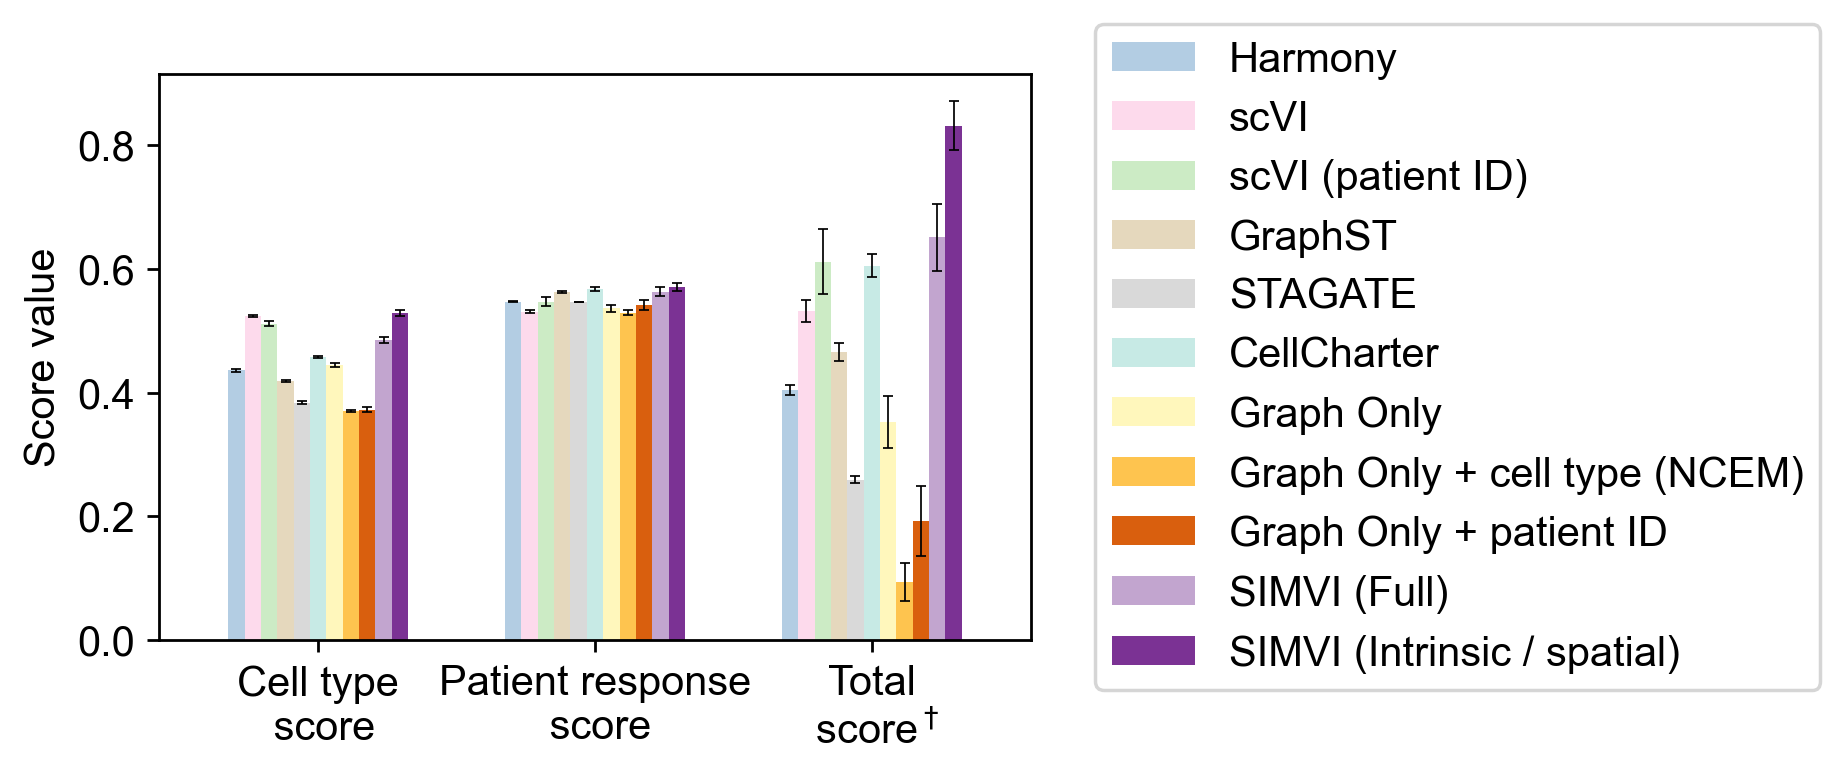

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Arial'
plt.rcParams['figure.dpi'] = 250
plt.rcParams["font.size"] = 12
fig, axs = plt.subplots(figsize=(4,2))
error_bar_style = {'elinewidth': 0.5, 
                   'ecolor': 'black',
                   'capsize': 1.5,   
                   'capthick': 0.5}  

color_list = ['#b3cde3','#fddaec','#ccebc5','#e5d8bd','#d9d9d9','#c7eae5','#fff7bc','#fec44f','#d95f0e','#c2a5cf','#7b3294']
df_summary_mean.T.plot(kind="bar",rot=0,edgecolor='none',color=color_list,figsize=(4.5,3),ax=axs,yerr=df_summary_ste.T, error_kw=error_bar_style,width=0.65)

axs.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
axs.set_ylabel('Score value')
plt.savefig('cosmx_benchmarking_main_updated.pdf',bbox_inches='tight')